<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_IC50_regress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных:

In [5]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.4 MB/s eta 0:00:00


In [6]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, make_scorer

# Регрессия с трансформацией цели
from sklearn.compose import TransformedTargetRegressor

from pickle import TRUE
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import joblib

Mounted at /content/drive


In [7]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade_df = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['CC50', 'SI'])
pca_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'pca_cleaned_IC50.csv'))
tsne_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_IC50.csv'))
umap_cleaned_IC50 = pd.read_csv(os.path.join(data_dir,'umap_cleaned_IC50.csv'))

In [8]:
# @title Подготовка данных для моделирования
analyse_name = 'regres'
base_parameter = 'IC50'

# подготовка данных для handmade_df
metod_name_1 = 'df_handmade'
X1 = handmade_df.drop(columns=[base_parameter])
y1 = handmade_df[base_parameter]
base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
csv_file_1 = f"results_{base_name1}.csv"
comparison_file_1 = f"comparison_{base_name1}_"
model_file_1 = f"model_{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'
X2 = pca_cleaned_IC50.drop(columns=[base_parameter])
y2 = pca_cleaned_IC50[base_parameter]
base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
csv_file_2 = f"results_{base_name2}.csv"
comparison_file_2 = f"comparison_{base_name2}_"
model_file_2 = f"model_{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'
X3 = tsne_cleaned_IC50.drop(columns=[base_parameter])
y3 = tsne_cleaned_IC50[base_parameter]
base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
csv_file_3 = f"results_{base_name3}.csv"
comparison_file_3 = f"comparison_{base_name3}_"
model_file_3 = f"model_{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'
X4 = umap_cleaned_IC50.drop(columns=[base_parameter])
y4 = umap_cleaned_IC50[base_parameter]
base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
csv_file_4 = f"results_{base_name4}.csv"
comparison_file_4 = f"comparison_{base_name4}_"
model_file_4 = f"model_{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [40]:
# @title класс RegressionModelEvaluator для анализа моделей регрессии
class RegressionModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 log_target=False, models_config=None, metod_name=""):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.log_target = log_target
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name

        # проверка данных
        if log_target and (self.y <= 0).any():
            raise ValueError("все значения y должны быть положительными")

        # логарифмирование целевой переменной
        epsilon = 1e-8
        self.y_transformed = np.log1p(self.y + epsilon) if log_target else self.y

        # разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y_transformed,
            test_size=test_size,
            random_state=random_state
        )

        # инициализация моделей
        if models_config is None:
            self.models = create_models_config(random_state)
        else:
            self.models = models_config

    def create_models_config(random_state=42):
        models_config = {
            # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
            'Ridge': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Ridge()
                ),
                'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
            },
            'Lasso': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Lasso()
                ),
                'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
            },
            'ElasticNet': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    ElasticNet()
                ),
                'params': {
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
                }
            },
            # Метод опорных векторов (SVR)
            'SVR': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVR()
                ),
                'params': {
                    'svr__kernel': ['linear', 'rbf', 'poly'],
                    'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
                }
            },
            # Метод k-ближайших соседей (KNN)
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
                'params': {
                    'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsregressor__weights': ['uniform', 'distance'],
                    'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
                }
            },
            # модели деревьев
            'DecisionTree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5]
                }
            },
            'RandomForest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5],
                    'max_features': ['sqrt', 0.8]
                }
            },
            # Бустеры
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [None, 5, 10],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            },
            # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
            #'GLM_Gamma': {
            #    'model': make_pipeline(
            #        StandardScaler(),
            #        TweedieRegressor(power=2, link='log', max_iter=1000)
            #    ),
            #   'params': {
            #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
            #       'tweedieregressor__max_iter': [1000]
            #   }
            #},
            'XGBoost_Tweedie': {
                'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
                'params': {
                    'n_estimators': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost_Tweedie': {
                'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            }
        }
        return models_config


    def evaluate_models(self):
        results = []

        # функция для RMSE
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        # make_scorer на основе RMSE
        rmse_scorer = make_scorer(rmse, greater_is_better=False)

        # перебираем модели и гиперпараметры
        for name, model_info in self.models.items():
            model = model_info['model']
            params = model_info['params']

            # подбор параметров через гридсерч
            gs = GridSearchCV(
                model,
                params,
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(self.X_train, self.y_train)

            # лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = -gs.best_score_

            # предсказания
            y_pred = best_model.predict(self.X_test)

            # метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV MSE': cv_score,
                'Test MSE': mean_squared_error(self.y_test, y_pred),
                'Test RMSE': rmse(self.y_test, y_pred),
                'Test MAE': mean_absolute_error(self.y_test, y_pred),
                'Test R2': r2_score(self.y_test, y_pred),
                'Test Explained Variance': explained_variance_score(self.y_test, y_pred),
                'Test Max Error': max_error(self.y_test, y_pred),
                'Test MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'Log Target': self.log_target,
                'Model Object': best_model  # сохраняем саму модель для последующего использования
            }

            results.append(metrics)
            print(f"{name} Test MSE: {metrics['Test MSE']:.3f}")

            # сохраняем лучшую модель
            if self.best_model is None or metrics['Test MSE'] < self.best_model[1]:
                self.best_model = (best_model, metrics['Test MSE'])

        # сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test MSE')

        return self.results

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            model_info = {
                'name': model_name,
                'model': self.results.loc[model_name, 'Model Object'],
                'metrics': self.results.loc[model_name].to_dict()
            }
            top_models.append(model_info)

        return top_models

    def save_top_models(self, n=3, prefix='model_',
                       data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        os.makedirs(data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        # сохраняем модели
        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_models_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)

        # создаем DataFrame с метриками
        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Model Object', None)
            metrics.pop('Best Parameters', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X, inverse_transform=False):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        preds = self.best_model[0].predict(X)

        if self.log_target and inverse_transform:
            return np.expm1(preds)
        return preds


    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")
        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)
        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")
            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

    def compare_top_models_predictions(self, n=3, plot=True, figsize=(15, 10)):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")
        top_models = self.get_top_models(n)
        # Dataаrame для сравнения
        comparison_df = pd.DataFrame({
            'Actual': self.y if not self.log_target else np.expm1(self.y_transformed)
        })
        # предсказания каждой модели
        for model_info in top_models:
            model_name = model_info['name']
            model = model_info['model']

            # предсказания (с обратным преобразованием если нужно)
            preds = model.predict(self.X)
            if self.log_target:
                preds = np.expm1(preds)

            comparison_df[f'Predicted_{model_name}'] = preds

        if plot:
            plt.figure(figsize=figsize)
            # график фактических и предсказанных значений
            for i, model_info in enumerate(top_models, 1):
                model_name = model_info['name']
                plt.subplot(2, 2, i)
                sns.scatterplot(x='Actual', y=f'Predicted_{model_name}', data=comparison_df)
                plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         'r--')
                plt.title(f'Actual vs Predicted ({model_name})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')

            # график распределения ошибок
            plt.subplot(2, 2, 4)
            for model_info in top_models:
                model_name = model_info['name']
                errors = comparison_df['Actual'] - comparison_df[f'Predicted_{model_name}']
                sns.kdeplot(errors, label=model_name)
            plt.title('Distribution of Prediction Errors')
            plt.xlabel('Prediction Error')
            plt.legend()

            plt.tight_layout()
            plt.show()

        # расчет метрик ошибок
        metrics_comparison = []
        for model_info in top_models:
            model_name = model_info['name']
            actual = comparison_df['Actual']
            predicted = comparison_df[f'Predicted_{model_name}']

            metrics = {
                'Model': model_name,
                'Full Dataset MSE': mean_squared_error(actual, predicted),
                'Full Dataset RMSE': np.sqrt(mean_squared_error(actual, predicted)),
                'Full Dataset MAE': mean_absolute_error(actual, predicted),
                'Full Dataset R2': r2_score(actual, predicted),
                'Full Dataset MAPE': mean_absolute_percentage_error(actual, predicted)
            }
            metrics_comparison.append(metrics)

        metrics_df = pd.DataFrame(metrics_comparison).set_index('Model')

        return comparison_df, metrics_df

    def save_comparison_results(self, n=3, prefix='comparison_',
                              data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        os.makedirs(data_dir, exist_ok=True)
        comparison_df, metrics_df = self.compare_top_models_predictions(n, plot=False)

        # сохраняем предсказания
        predictions_filename = f"{prefix}top_{n}_predictions.csv"
        predictions_filepath = os.path.join(data_dir, predictions_filename)
        comparison_df.to_csv(predictions_filepath, index=False)
        print(f"Предсказания топ-{n} моделей сохранены в {predictions_filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_full_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)
        metrics_df.to_csv(metrics_filepath)
        print(f"Метрики топ-{n} моделей на всем датасете сохранены в {metrics_filepath}")

        # сохраняем графики
        self.compare_top_models_predictions(n, plot=True)
        plot_filename = f"{prefix}top_{n}_comparison_plot.png"
        plot_filepath = os.path.join(data_dir, plot_filename)
        plt.savefig(plot_filepath, bbox_inches='tight')
        plt.close()
        print(f"Графики сравнения сохранены в {plot_filepath}")

        return {
            'predictions_file': predictions_filepath,
            'metrics_file': metrics_filepath,
            'plot_file': plot_filepath
        }

In [6]:
# @title Функция визуализации
def plot_prediction_comparison(x, y):
    # Вычисление ошибок предсказания
    errors = x - y

    plt.figure(figsize=(20, 5))

    # График рассеяния
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=x, y=y, alpha=0.5, label='Предсказанные vs Реальные')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальная линия')
    plt.xlabel('Реальные значения IC50')
    plt.ylabel('Предсказанные значения IC50')
    plt.title('Сравнение предсказанных и реальных значений IC50')
    plt.legend()
    plt.tight_layout()

    # Гистограмма ошибок
    plt.subplot(1, 2, 2)
    sns.histplot(errors, bins=30, kde=True, color='purple', alpha=0.6)
    plt.title('Гистограмма ошибок предсказания')
    plt.xlabel('Ошибка предсказания (Реальное - Предсказанное)')
    plt.ylabel('Частота')

    plt.show()

Ridge Test MSE: 384.074
Lasso Test MSE: 250.897
ElasticNet Test MSE: 969.464
SVR Test MSE: 228.290
KNN Test MSE: 220.128
DecisionTree Test MSE: 275.244
ExtraTrees Test MSE: 232.020
RandomForest Test MSE: 227.160
GradientBoosting Test MSE: 224.034
HistGradientBoosting Test MSE: 221.689
XGBoost Test MSE: 235.384
CatBoost Test MSE: 206.531
XGBoost_Tweedie Test MSE: 215.465
CatBoost_Tweedie Test MSE: 225.968
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_df_handmade_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_df_handmade_top_3_full_metrics.csv


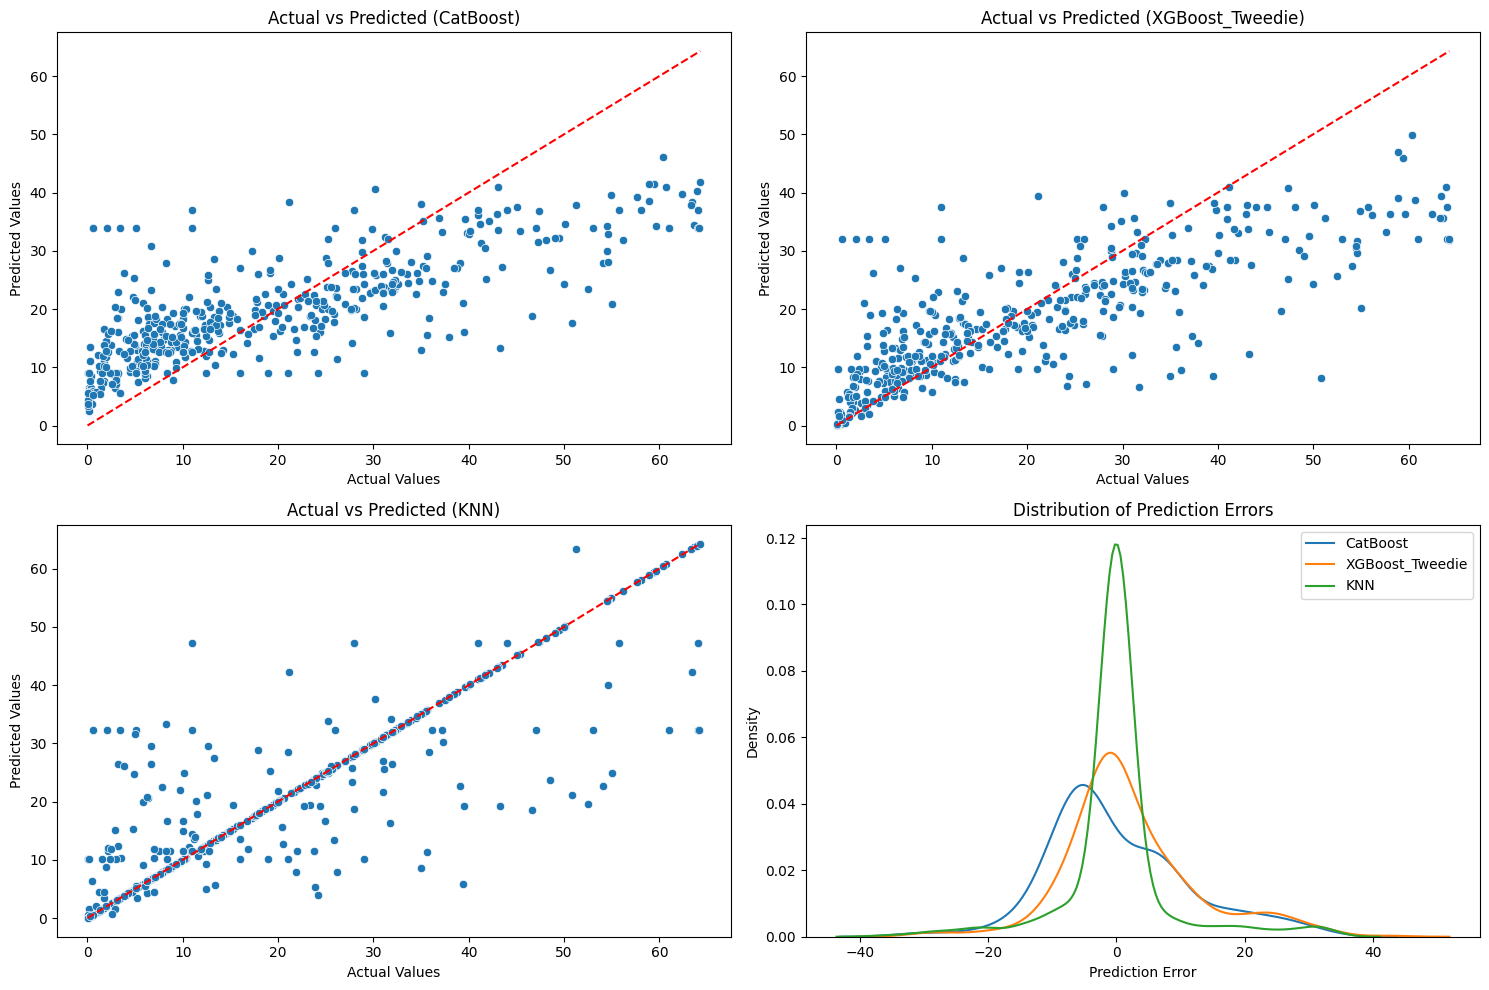

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_df_handmade_top_3_comparison_plot.png
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_catboost.pkl
Модель XGBoost_Tweedie сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_xgboost_tweedie.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_knn.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_xgboost_tweedie.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_knn.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_df_handmade_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на руяных данных
# инициализация
evaluator_handmade_df = RegressionModelEvaluator(X1, y1, log_target=False) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_handmade_df.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_1 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_handmade_df = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_handmade_df.predict(X1, inverse_transform=False) # ПОМЕНЯТЬ ТУТ!
predictions_handmade_df = predictions

# сохраненние общего результата
results_handmade_df_id = results_handmade_df.reset_index()
results_handmade_df_id.to_csv(os.path.join(data_dir, csv_file_1), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_handmade_df.save_comparison_results(n=3, prefix=comparison_file_1, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_handmade_df.save_top_models(n=3, prefix=model_file_1 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_handmade_df.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
CatBoost,df_handmade,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",235.534815,206.531177,14.371193,12.110393,0.197830,0.198258,34.037779,2.800038,False,<catboost.core.CatBoostRegressor object at 0x7...
XGBoost_Tweedie,df_handmade,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",269.809132,215.465206,14.678733,11.474785,0.163131,0.211731,42.674440,1.088688,False,"XGBRegressor(base_score=None, booster=None, ca..."
KNN,df_handmade,"{'kneighborsregressor__n_neighbors': 7, 'kneig...",247.464427,220.128152,14.836716,11.565802,0.145020,0.146042,36.196098,1.463791,False,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
HistGradientBoosting,df_handmade,"{'learning_rate': 0.05, 'max_depth': None, 'ma...",252.361774,221.688516,14.889208,11.875536,0.138959,0.138972,43.166512,1.851660,False,HistGradientBoostingRegressor(learning_rate=0....
GradientBoosting,df_handmade,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",249.301796,224.033887,14.967762,12.583474,0.129850,0.132495,35.211052,3.274791,False,([DecisionTreeRegressor(criterion='friedman_ms...


Ridge Test MSE: 305.857
Lasso Test MSE: 232.100
ElasticNet Test MSE: 391.924
SVR Test MSE: 241.240
KNN Test MSE: 244.523
DecisionTree Test MSE: 342.250
ExtraTrees Test MSE: 219.515
RandomForest Test MSE: 219.721
GradientBoosting Test MSE: 202.707
HistGradientBoosting Test MSE: 228.583
XGBoost Test MSE: 230.189
CatBoost Test MSE: 205.302
XGBoost_Tweedie Test MSE: 266.691
CatBoost_Tweedie Test MSE: 245.633
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_pca_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_pca_top_3_full_metrics.csv


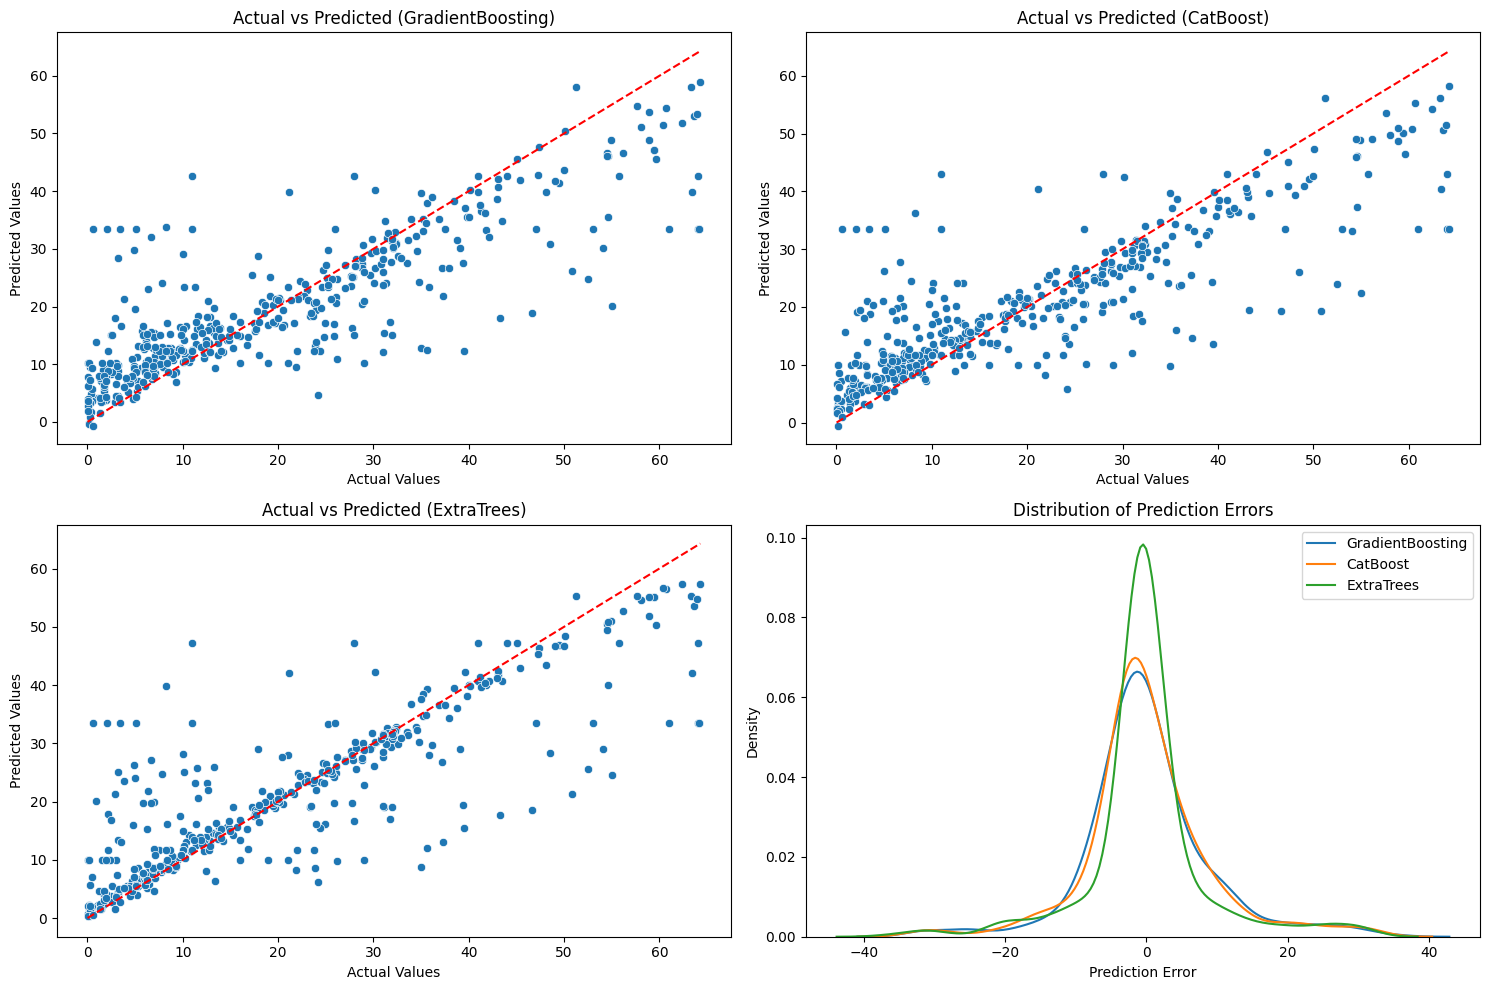

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_pca_top_3_comparison_plot.png
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_gradientboosting.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_catboost.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_extratrees.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_gradientboosting.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_extratrees.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_pca_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных PCA(50 параметров)
# Инициализация
evaluator_pca = RegressionModelEvaluator(X2, y2, log_target=False)

# Оценка моделей
results = evaluator_pca.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_pca = results.copy()
results_pca['metod'] = metod_name_2 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_pca = results_pca[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_pca.predict(X2, inverse_transform=False)
predictions_pca = predictions

# Сохраненние результата
results_pca_id = results_pca.reset_index()
results_pca_id.to_csv(os.path.join(data_dir, csv_file_2), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_pca.save_comparison_results(n=3, prefix=comparison_file_2, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_pca.save_top_models(n=3, prefix=model_file_2 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_pca.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
GradientBoosting,pca,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",253.687164,202.707192,14.237528,11.661723,0.212683,0.213973,34.874945,3.700942,False,([DecisionTreeRegressor(criterion='friedman_ms...
CatBoost,pca,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",240.032077,205.301631,14.328351,11.871245,0.202606,0.202764,32.502870,3.452690,False,<catboost.core.CatBoostRegressor object at 0x7...
ExtraTrees,pca,"{'max_depth': None, 'min_samples_split': 5, 'n...",236.630655,219.514969,14.816038,12.141212,0.147401,0.147789,36.196098,2.181625,False,"(ExtraTreeRegressor(min_samples_split=5, rando..."
RandomForest,pca,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",243.046088,219.721217,14.822996,12.436893,0.146600,0.146616,34.918652,3.892474,False,"(DecisionTreeRegressor(max_depth=20, max_featu..."
HistGradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': None, 'ma...",255.051922,228.582765,15.118954,12.109797,0.112182,0.114698,35.647722,1.972685,False,HistGradientBoostingRegressor(learning_rate=0....


Ridge Test MSE: 263.341
Lasso Test MSE: 259.776
ElasticNet Test MSE: 264.803
SVR Test MSE: 283.490
KNN Test MSE: 235.031
DecisionTree Test MSE: 334.762
ExtraTrees Test MSE: 241.481
RandomForest Test MSE: 252.029
GradientBoosting Test MSE: 300.696
HistGradientBoosting Test MSE: 267.692
XGBoost Test MSE: 289.565
CatBoost Test MSE: 238.010
XGBoost_Tweedie Test MSE: 283.361
CatBoost_Tweedie Test MSE: 259.523
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_tsne_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_tsne_top_3_full_metrics.csv


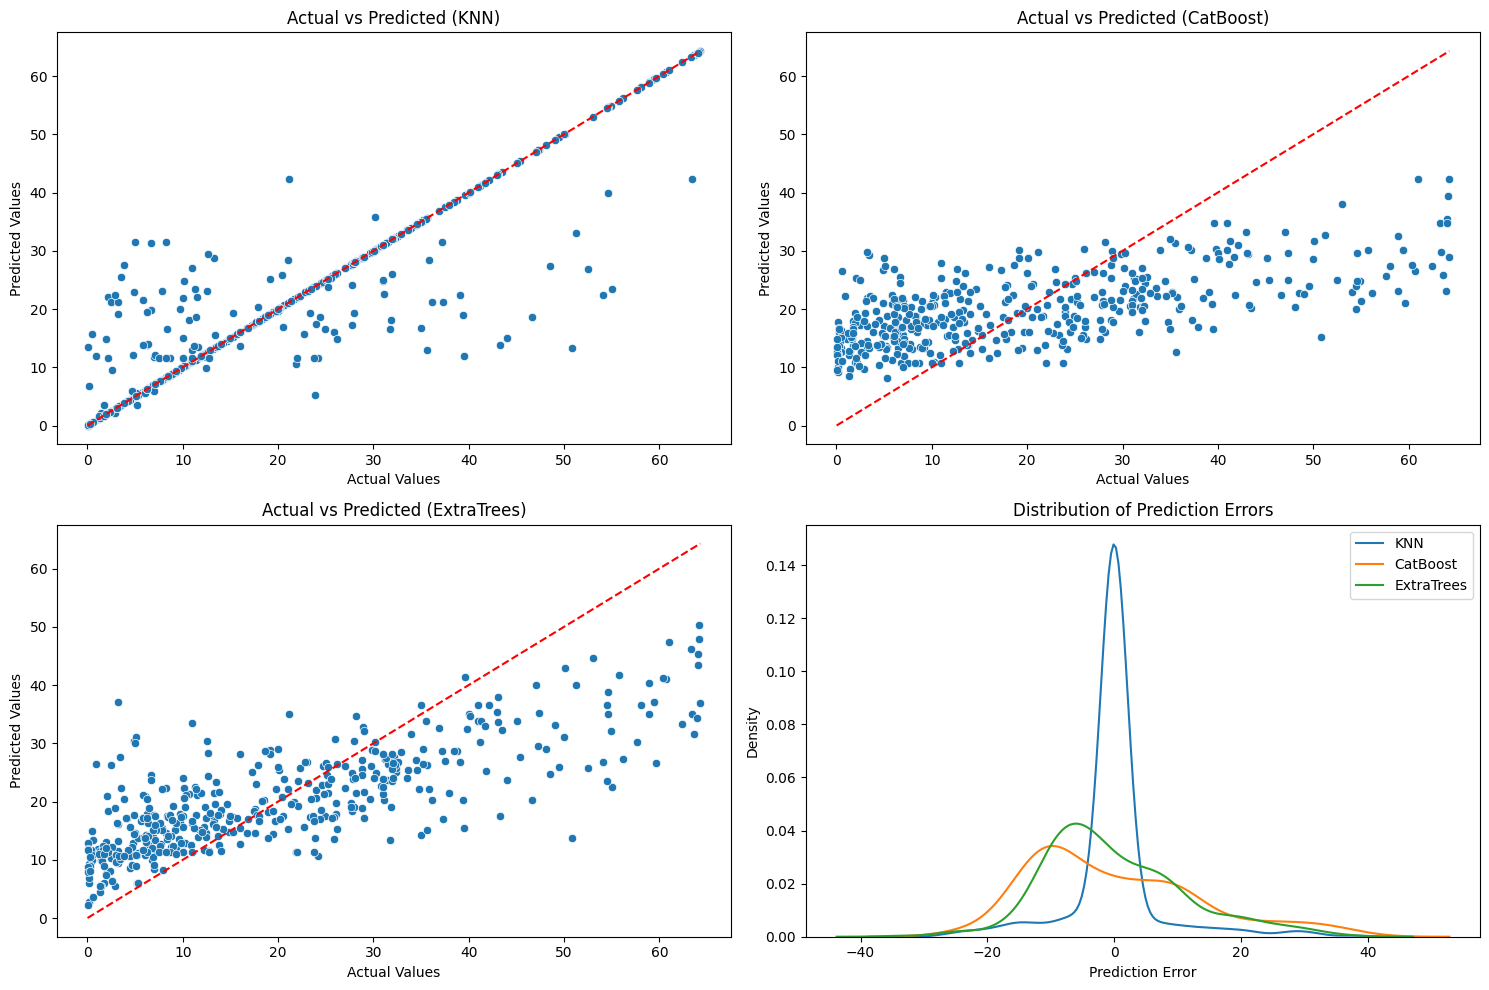

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_tsne_top_3_comparison_plot.png
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_knn.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_catboost.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_extratrees.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_knn.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_extratrees.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_tsne_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSME(3 параметра)
# Инициализация
evaluator_tsne = RegressionModelEvaluator(X3, y3, log_target=False)

# Оценка моделей
results = evaluator_tsne.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_tsne = results.copy()
results_tsne['metod'] = metod_name_3
columns_order = ['metod'] + [col for col in results.columns]
results_tsne = results_tsne[columns_order]


# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_tsne.predict(X3, inverse_transform=False)
predictions_tsne_cleaned = predictions

# Сохраненние результата
results_tsne_id = results_tsne.reset_index()
results_tsne_id.to_csv(os.path.join(data_dir, csv_file_3), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_tsne.save_comparison_results(n=3, prefix=comparison_file_3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_tsne.save_top_models(n=3, prefix=model_file_3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_tsne.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
KNN,tsne,"{'kneighborsregressor__n_neighbors': 12, 'knei...",266.000747,235.030551,15.330706,12.796879,0.087139,0.087347,37.634935,5.690291,False,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
CatBoost,tsne,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",270.776143,238.009556,15.427558,13.408544,0.075568,0.075577,35.659434,5.911402,False,<catboost.core.CatBoostRegressor object at 0x7...
ExtraTrees,tsne,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",266.875613,241.480873,15.539655,13.351809,0.062085,0.062408,37.203355,5.443511,False,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
RandomForest,tsne,"{'max_depth': None, 'max_features': 'sqrt', 'm...",274.929682,252.028882,15.875418,13.675930,0.021117,0.021501,36.291539,5.548447,False,"(DecisionTreeRegressor(max_features='sqrt', mi..."
CatBoost_Tweedie,tsne,"{'depth': 3, 'iterations': 200, 'l2_leaf_reg':...",281.360387,259.523253,16.109725,13.784989,-0.007991,-0.002131,35.461432,6.795903,False,<catboost.core.CatBoostRegressor object at 0x7...


Ridge Test MSE: 266.883
Lasso Test MSE: 262.290
ElasticNet Test MSE: 269.183
SVR Test MSE: 280.662
KNN Test MSE: 242.668
DecisionTree Test MSE: 260.953
ExtraTrees Test MSE: 238.035
RandomForest Test MSE: 235.517
GradientBoosting Test MSE: 237.815
HistGradientBoosting Test MSE: 235.713
XGBoost Test MSE: 252.190
CatBoost Test MSE: 249.852
XGBoost_Tweedie Test MSE: 239.833
CatBoost_Tweedie Test MSE: 247.937
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_umap_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_umap_top_3_full_metrics.csv


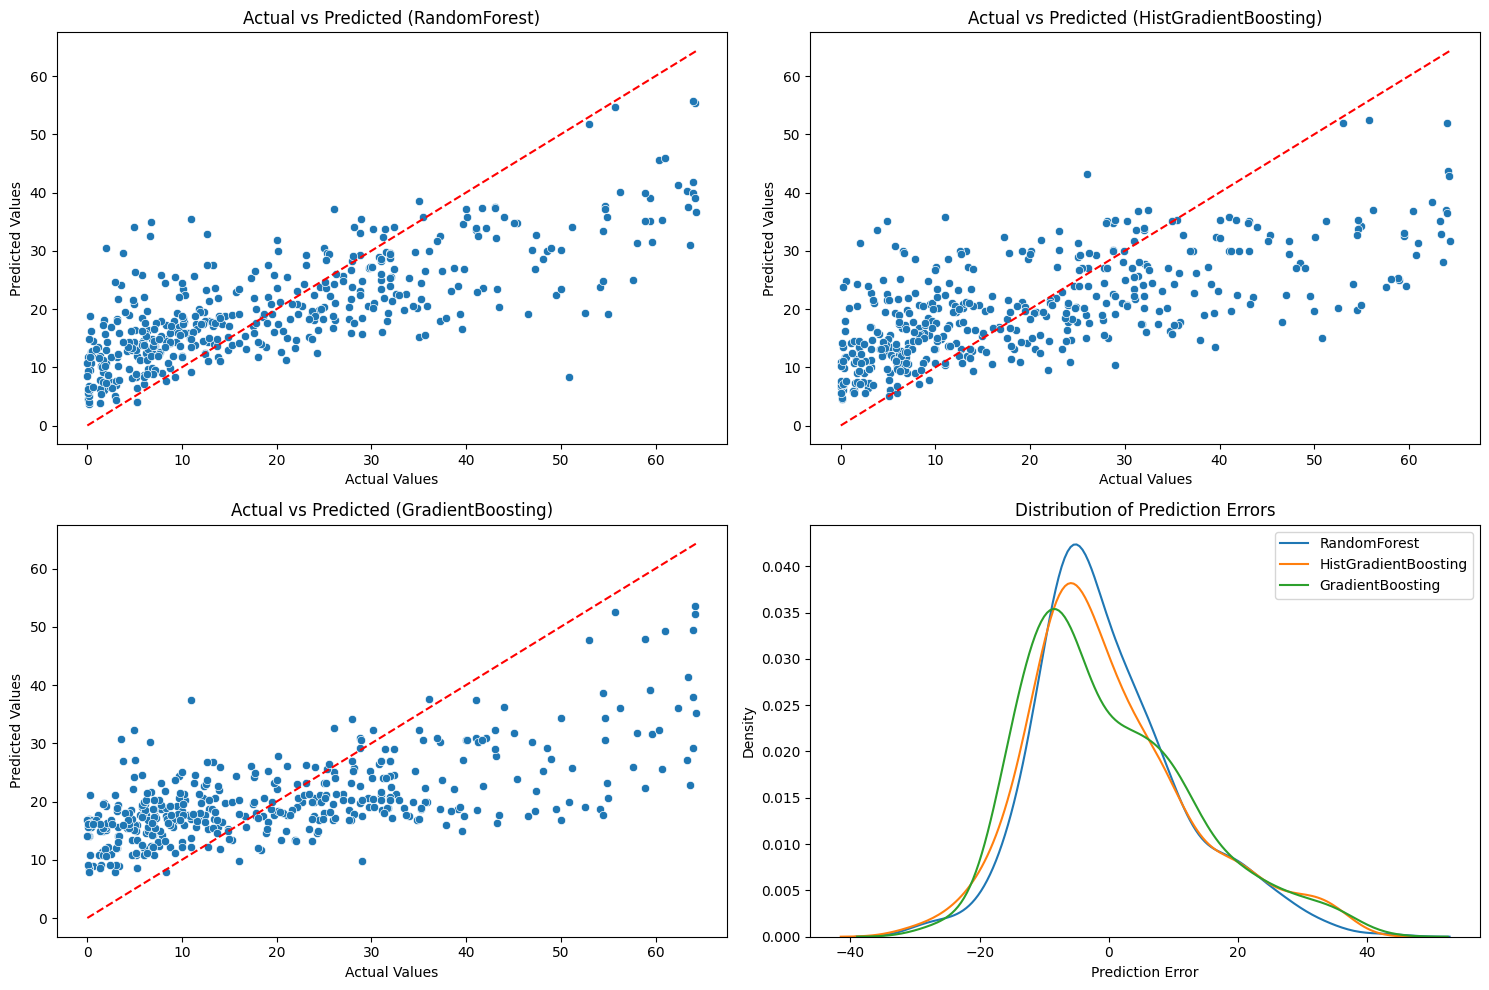

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_IC50_regres_umap_top_3_comparison_plot.png
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_randomforest.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_histgradientboosting.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_gradientboosting.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_randomforest.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_histgradientboosting.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_gradientboosting.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_IC50_regres_umap_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP (3 параметра)

# Инициализация
evaluator_umap = RegressionModelEvaluator(X4, y4, log_target=False)

# Оценка моделей
results = evaluator_umap.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_umap = results.copy()
results_umap['metod'] = metod_name_4
columns_order = ['metod'] + [col for col in results.columns]
results_umap = results_umap[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_umap.predict(X4, inverse_transform=False)
predictions_umap = predictions

# Сохраненние результата
results_umap_id = results_umap.reset_index()
results_umap_id.to_csv(os.path.join(data_dir, csv_file_4), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_umap.save_comparison_results(n=3, prefix=comparison_file_4, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_umap.save_top_models(n=3, prefix=model_file_4 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_umap.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
RandomForest,umap,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",258.013641,235.516750,15.346555,12.556097,0.085250,0.085424,42.591198,4.480027,False,"(DecisionTreeRegressor(max_depth=10, max_featu..."
HistGradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 5, 'max_i...",265.988963,235.713490,15.352964,12.584735,0.084486,0.084505,35.755010,3.938979,False,HistGradientBoostingRegressor(learning_rate=0....
GradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",270.948458,237.814693,15.421242,12.992227,0.076325,0.076570,35.372573,6.449377,False,([DecisionTreeRegressor(criterion='friedman_ms...
ExtraTrees,umap,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",262.679897,238.035001,15.428383,12.722661,0.075469,0.075812,39.945162,4.444785,False,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
XGBoost_Tweedie,umap,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",278.634527,239.833223,15.486550,12.569025,0.068485,0.087817,48.546924,5.264641,False,"XGBRegressor(base_score=None, booster=None, ca..."


# СВОД И ВЫВОДЫ


In [37]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [csv_file_1, csv_file_2, csv_file_3, csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test MSE', ascending=True)
combined_results_for_view.head(5)

,Model,metod,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Data_Type
14,GradientBoosting,pca,253.687164,202.707192,14.237528,11.661723,0.212683,0.213973,34.874945,3.700942,False,"GradientBoostingRegressor(min_samples_split=5,...",IC50
15,CatBoost,pca,240.032077,205.301631,14.328351,11.871245,0.202606,0.202764,32.502870,3.452690,False,<catboost.core.CatBoostRegressor object at 0x7...,IC50
0,CatBoost,df_handmade,235.534815,206.531177,14.371193,12.110393,0.197830,0.198258,34.037779,2.800038,False,<catboost.core.CatBoostRegressor object at 0x7...,IC50
1,XGBoost_Tweedie,df_handmade,269.809132,215.465206,14.678733,11.474785,0.163131,0.211731,42.674440,1.088688,False,"XGBRegressor(base_score=None, booster=None, ca...",IC50
16,ExtraTrees,pca,236.630655,219.514969,14.816038,12.141212,0.147401,0.147789,36.196098,2.181625,False,"ExtraTreesRegressor(min_samples_split=5, n_est...",IC50


In [39]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "KNN") & (combined_results['metod'] == "tsne")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'kneighborsregressor__n_neighbors': 12, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}"

In [36]:
# @title Датасет с результатами 12 моделей на всех данных
top3_csv_file_1 = f"{comparison_file_1}top_3_full_metrics.csv"
top3_csv_file_2 = f"{comparison_file_2}top_3_full_metrics.csv"
top3_csv_file_3 = f"{comparison_file_3}top_3_full_metrics.csv"
top3_csv_file_4 = f"{comparison_file_4}top_3_full_metrics.csv"

# Список файлов с результатами
result_files = [top3_csv_file_1, top3_csv_file_2, top3_csv_file_3, top3_csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[3]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
final_results = pd.concat(dfs, ignore_index=False)

# Выводим первые строки для проверки
final_results_for_view = final_results.sort_values(by='Full Dataset MSE', ascending=True)
final_results_for_view.head(5)

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE,Data_Type
0,KNN,51.023463,7.143071,2.905141,0.819432,1.179596,tsne
2,KNN,71.371035,8.448138,3.705033,0.747423,0.936185,df
2,ExtraTrees,74.161059,8.611682,4.777204,0.737550,1.566343,pca
1,CatBoost,80.098208,8.949760,5.975036,0.716539,3.123562,pca
0,GradientBoosting,81.327313,9.018166,6.050713,0.712189,3.807452,pca


# ТЮНИНГ

В этот раз без тюнинга, выиграла KNN